In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
from os.path import join, dirname
import os

import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import itertools
import pickle
import scipy
from IPython.display import display, Markdown, Latex

from plot_utils import lighten_boxplot
import admix

In [2]:
geno_sim_prefix = "EUR_0.2_AFR_0.8_7_80000"
geno_data_dir = f"data/geno/{geno_sim_prefix}/"

anc = np.load(join(geno_data_dir, "anc.npy"))
phgeno = np.load(join(geno_data_dir, "phgeno.npy"))
legend = pd.read_csv(join(geno_data_dir, "legend.csv"))

n_indiv = anc.shape[0] // 2
n_snp = anc.shape[1]
anc = anc.reshape(n_indiv, n_snp * 2)
phgeno = phgeno.reshape((n_indiv, n_snp * 2))
geno = admix.convert_anc_count(anc=anc, phgeno=phgeno)

# Allele frequency for the two ancestral populations

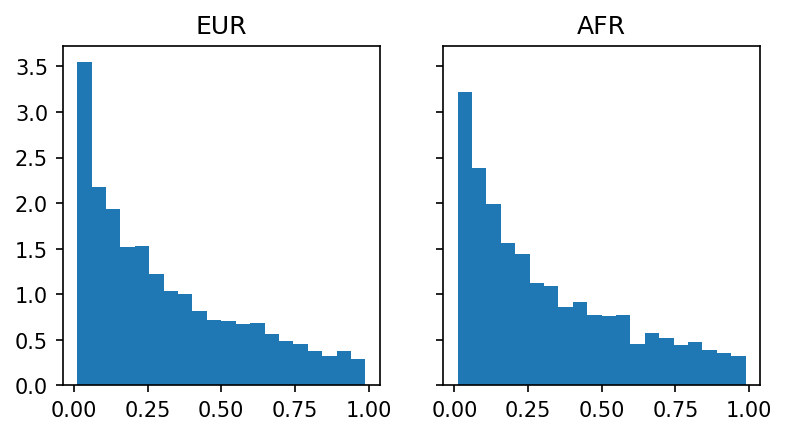

In [3]:
fig, axs = plt.subplots(figsize=(6, 3), ncols=2, sharex=True, sharey=True, dpi=150)
axs[0].hist(legend.EUR.values, bins=20, density=True)
axs[0].set_title("EUR")
axs[1].hist(legend.AFR.values, bins=20, density=True)
axs[1].set_title("AFR")
plt.show()

In [4]:
# read all data into `score_df_dict`
# which follows the structure: score_df_dict[control_ratio][{odds_ratio}_{anc_effect}] = ...
control_ratio_list = [1.0, 2.5]
odds_ratio_list = [1.0, 1.15, 1.2, 1.25]
anc_effect_list = [0.0, 0.5]

score_df_dict = {control_ratio: dict() for control_ratio in control_ratio_list}

for control_ratio in control_ratio_list:
    rls_dir = f"out/single_snp_test_tractor/{geno_sim_prefix}/0.1_{control_ratio}/"

    for odds_ratio in odds_ratio_list:
        for anc_effect in anc_effect_list:
            score_df_dict[control_ratio][(odds_ratio, anc_effect)] = pd.read_csv(join(rls_dir, f"{odds_ratio}_{anc_effect}", "summary.csv.gz"))

# Main Figure

Number of differentiated SNPs: 904


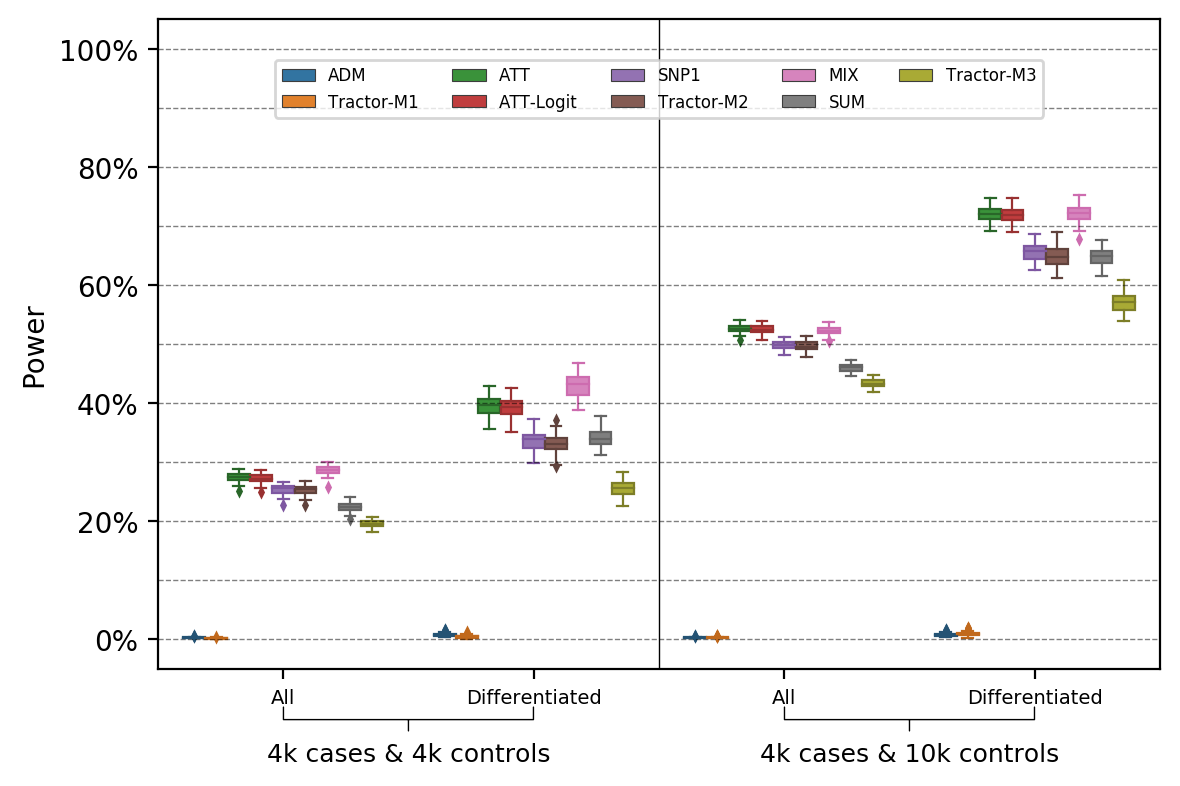

In [5]:
diff_snps = np.where(np.abs(legend.EUR.values - legend.AFR.values) > 0.2)[0]
print(f"Number of differentiated SNPs: {len(diff_snps)}")

odds_ratio = 1.2
anc_effect = 0.0
pval_df_4k = score_df_dict[1.0][(odds_ratio, anc_effect)].copy().dropna()
pval_df_10k = score_df_dict[2.5][(odds_ratio, anc_effect)].copy().dropna()

df = {"score": [], "sig_prop": [], "sim_i": [], "control_size": [], "only_diff_snp": []}

for control_size, raw_pval_df in zip(["4k", "10k"], [pval_df_4k, pval_df_10k]):
    for only_diff_snp in [False, True]:
        if only_diff_snp:
            pval_df = raw_pval_df[raw_pval_df.SNP_I.isin(diff_snps)].copy()
        else:
            pval_df = raw_pval_df.copy()
        
        for score in pval_df.columns[0:-2]:
            p_threshold = 1e-5 if score in ["ADM", "ADM_LOGISTIC"] else 5e-8
            sig_prop = pval_df.groupby("SIM_I").apply(lambda x: np.mean(x[score] < p_threshold))
            score_n_sim = len(sig_prop)
            df["score"].extend([score] * score_n_sim)
            df["sig_prop"].extend(sig_prop)
            df["sim_i"].extend(sig_prop.index.values)
            df["control_size"].extend([control_size] * score_n_sim)
            df["only_diff_snp"].extend([only_diff_snp] * score_n_sim)
            
df = pd.DataFrame(df)

df = df.replace({"ADM_LOGISTIC": "Tractor-M1",
                 "SNP1_LOGISTIC": "Tractor-M2",
                 "TRACTOR": "Tractor-M3",
                 "ATT_LOGISTIC": "ATT-Logit"})
df["xlabel"] = df.apply(lambda row: row["control_size"] + str(row["only_diff_snp"]), axis = 1)

# plotting
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
label_order = ["ADM", "Tractor-M1", "ATT", "ATT-Logit", "SNP1", "Tractor-M2",
                       "MIX", "SUM", "Tractor-M3"]

sns.boxplot(x="xlabel", y="sig_prop",
            hue="score",
            hue_order=label_order,
            width=0.8,
            linewidth=0.8,
            fliersize=2,
            data=df, ax=ax)


lighten_boxplot(ax)

ax.axvline(1.5, color='k', lw=0.5)
[ax.axhline(y=i, linestyle='--', color='k', alpha=0.5, lw=0.5) for i in np.linspace(0, 1, 11)]
ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])

ax.annotate('4k cases & 4k controls', xy=(0.25, -0.07), xytext=(0.25, -0.15), xycoords='axes fraction', 
            fontsize=9, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=5.0, lengthB=0.5', lw=0.5))

ax.annotate('4k cases & 10k controls', xy=(0.75, -0.07), xytext=(0.75, -0.15), xycoords='axes fraction', 
            fontsize=9, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=5.0, lengthB=0.5', lw=0.5))
plt.xlabel("")
plt.ylabel("Power")
ax.set_xticklabels(["All", "Differentiated"] * 2, fontsize=7)
plt.legend(loc='upper center', bbox_to_anchor=(0.5,0.95),
      ncol=5, fontsize=6)
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.savefig(f"manuscript/main.png", dpi=200, bbox_inches='tight')

# Full results

## Null simulation

## Proportion of false positive in the null simulation, under each scenerio and QQ-plot

,Sample size,Ancestry effect,ADM,ATT,MIX,SNP1,SUM,ADM_LOGISTIC,ATT_LOGISTIC,SNP1_LOGISTIC,TRACTOR
0,4k cases & 4k controls,0.0,0.039952,0.050173,0.049791,0.048588,0.043127,0.051194,0.049985,0.050200,0.051347
0,4k cases & 4k controls,0.5,0.039282,0.050241,0.050436,0.049329,0.043446,0.051153,0.050109,0.050345,0.049837
0,4k cases & 10k controls,0.0,0.039937,0.049731,0.049376,0.047925,0.042847,0.051328,0.049592,0.049446,0.049737
0,4k cases & 10k controls,0.5,0.039307,0.050369,0.050285,0.049430,0.041951,0.050807,0.050362,0.050083,0.050070


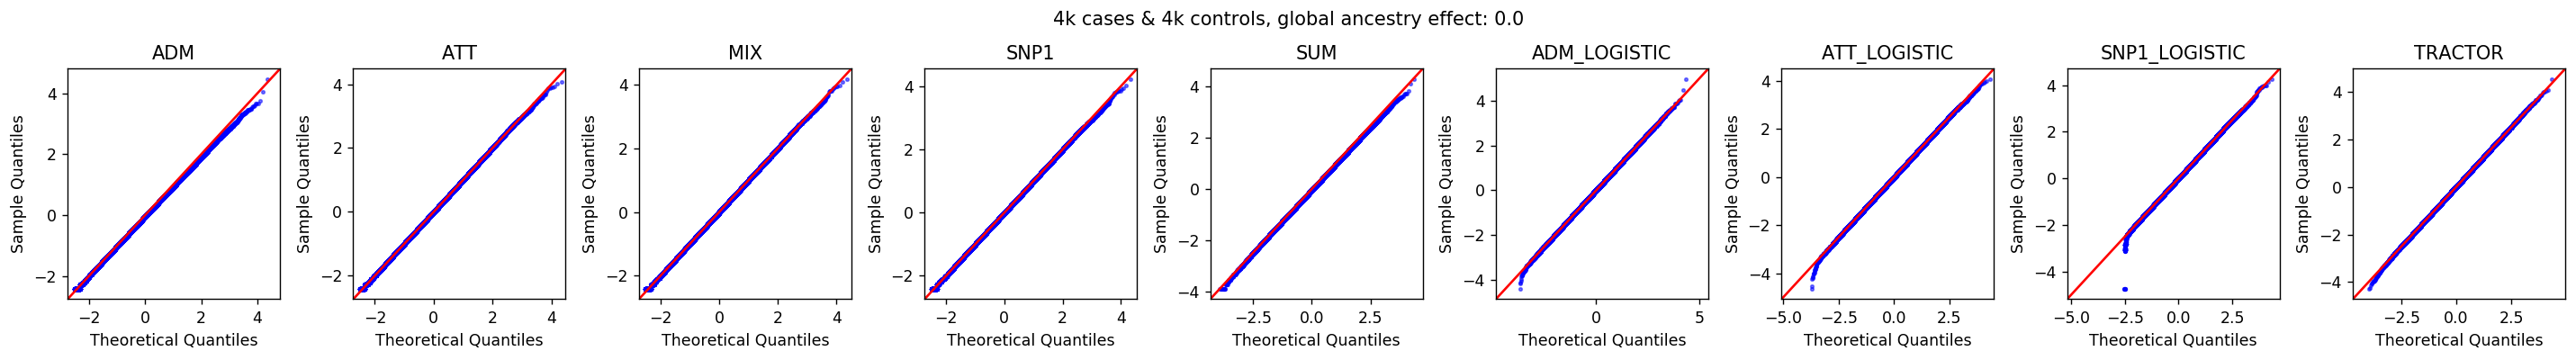

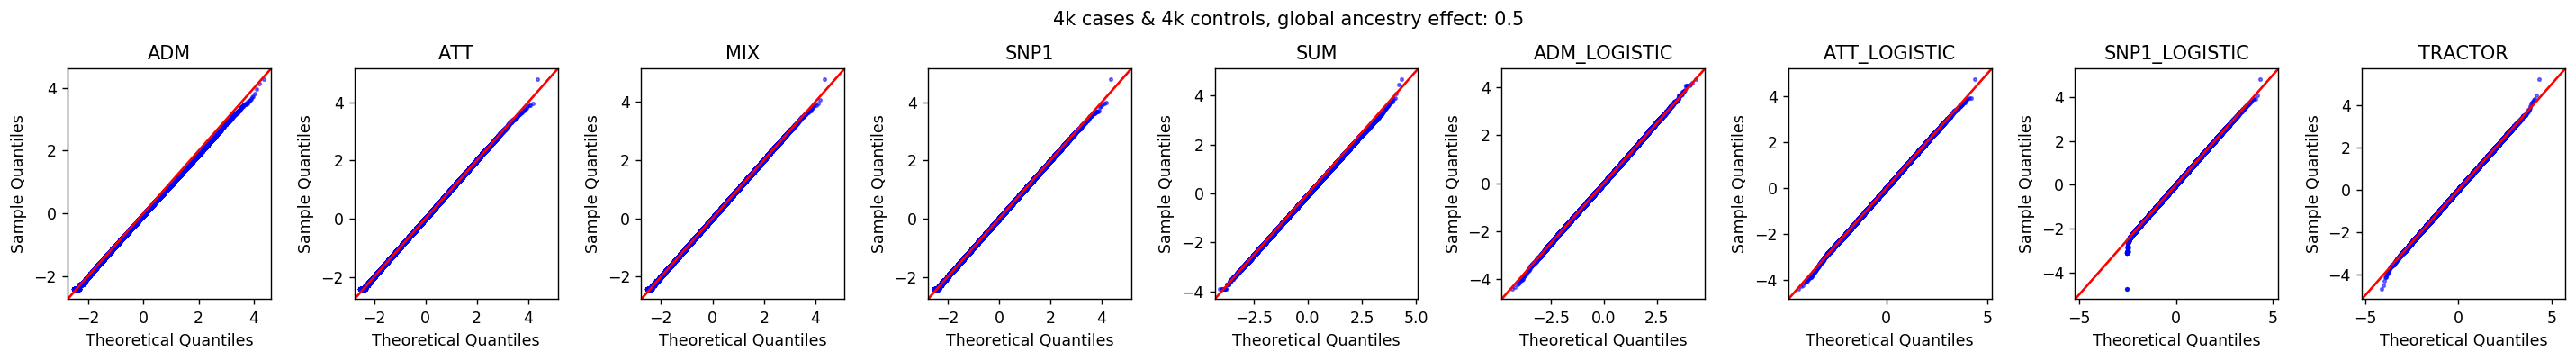

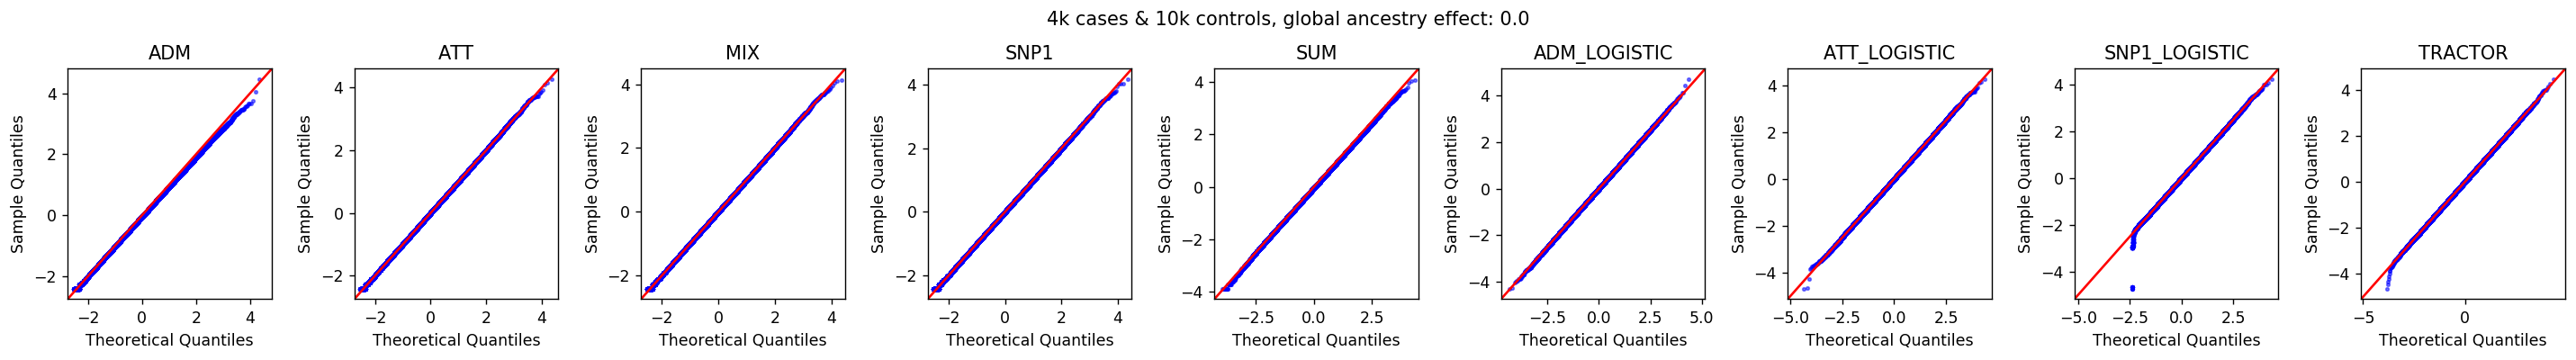

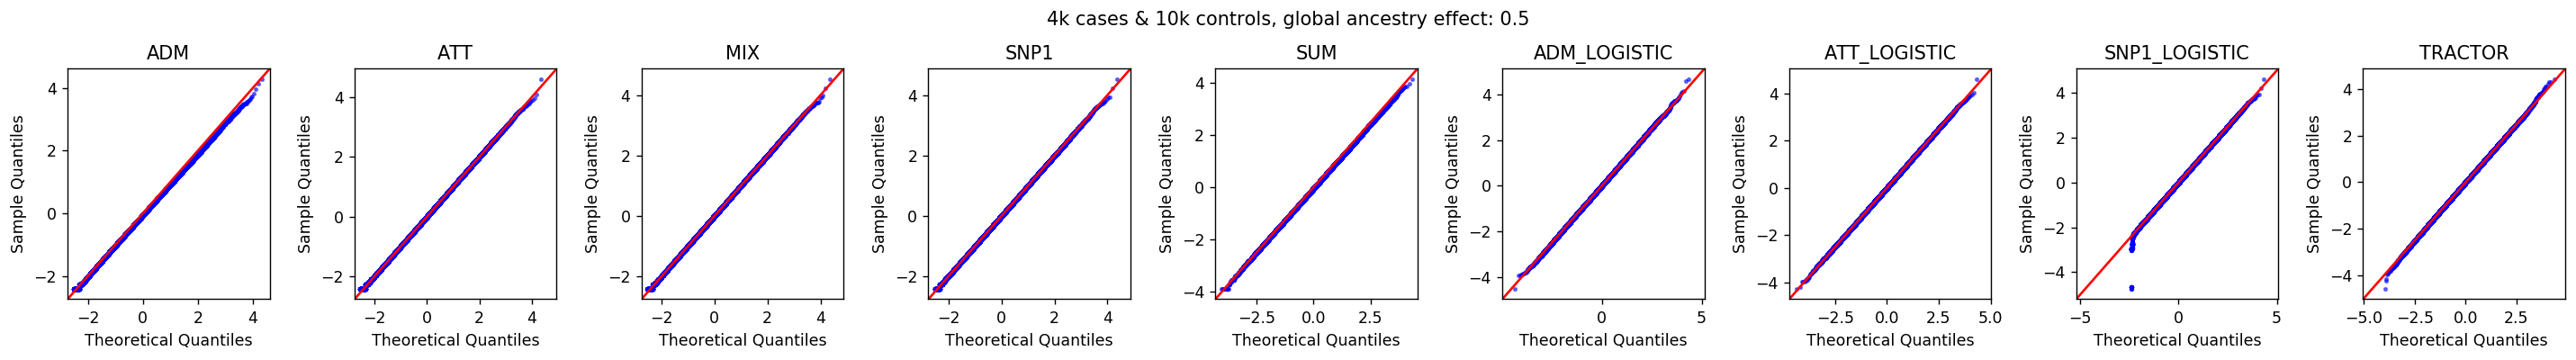

In [6]:
display(Markdown("## Proportion of false positive in the null simulation, under each scenerio and QQ-plot"))
fp_df = []
for control_ratio in control_ratio_list:
    for anc_effect in anc_effect_list:
        sample_size_text = "4k cases & 4k controls" if control_ratio == 1.0 else "4k cases & 10k controls"
        score_df = score_df_dict[control_ratio][(1.0, anc_effect)].copy().dropna()
        pval_df = score_df.iloc[:, 0:-2].copy()

        qq_fig, qq_axs = plt.subplots(1, pval_df.shape[1], figsize=(23,3), dpi=125)
        for col_i, col in enumerate(pval_df.columns):
            zsc = admix.pval2zsc(pval_df[col].values)
            sm.qqplot(zsc, line="45", markersize=2, alpha=0.5, ax=qq_axs[col_i])
            qq_axs[col_i].set_title(col)
        
        qq_fig.suptitle(f"{sample_size_text}, global ancestry effect: {anc_effect}", y=1.05)
        plt.tight_layout()
        df = pd.DataFrame((pval_df < 0.05).mean(axis=0)).T
        df["Sample size"] = sample_size_text
        df["Ancestry effect"] =  anc_effect
        fp_df.append(df)

fp_df = pd.concat(fp_df)
cols = fp_df.columns.tolist()
fp_df[cols[-2:] + cols[:-2]]

# Power simulation

## Sample size: 4k cases & 4k controls, global ancestry effect: 0.0 (all SNPs)

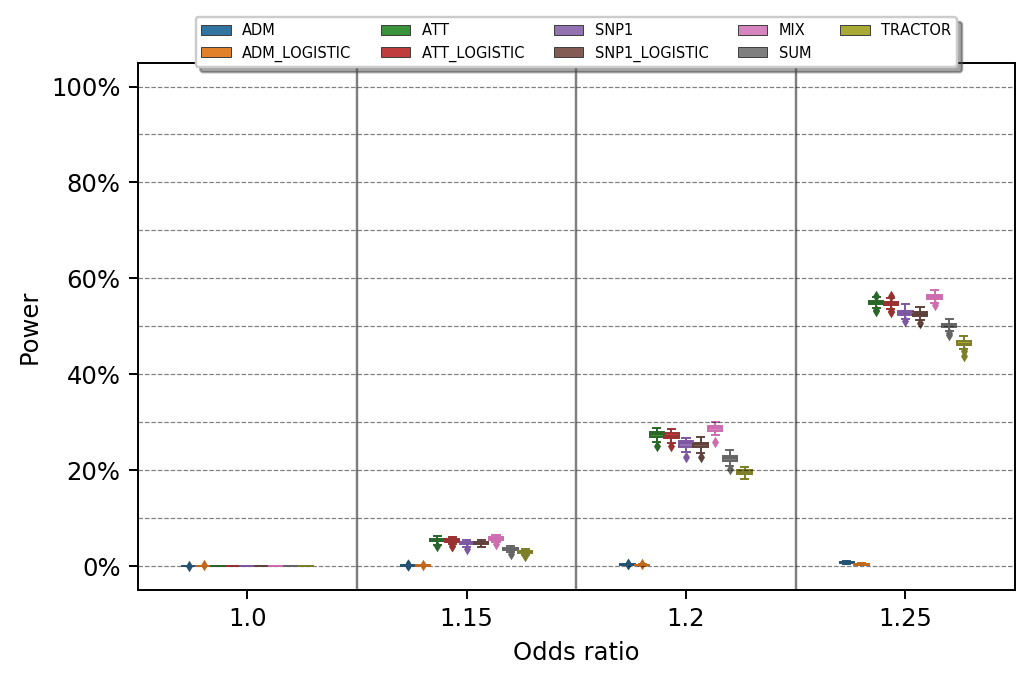

## Sample size: 4k cases & 4k controls, global ancestry effect: 0.0 (differentiated SNPs)

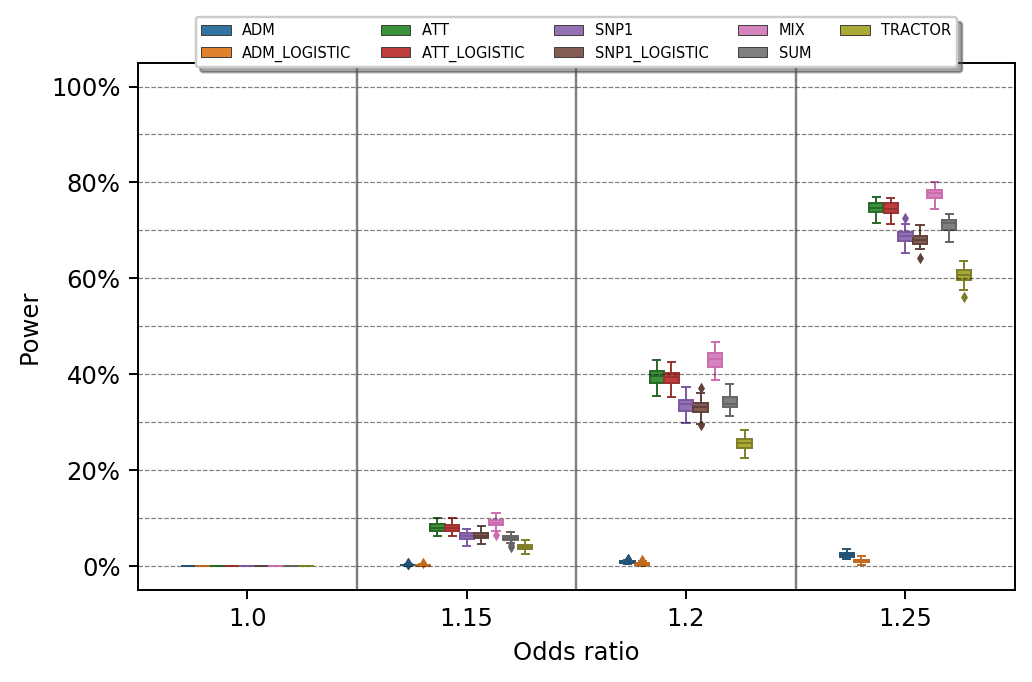

## Sample size: 4k cases & 4k controls, global ancestry effect: 0.5 (all SNPs)

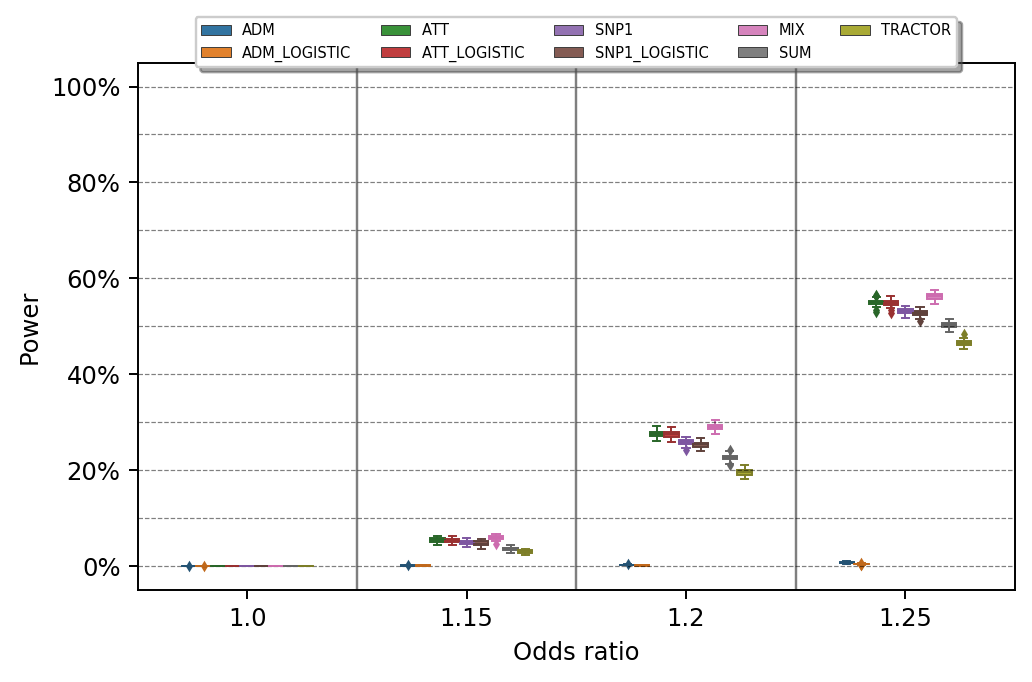

## Sample size: 4k cases & 4k controls, global ancestry effect: 0.5 (differentiated SNPs)

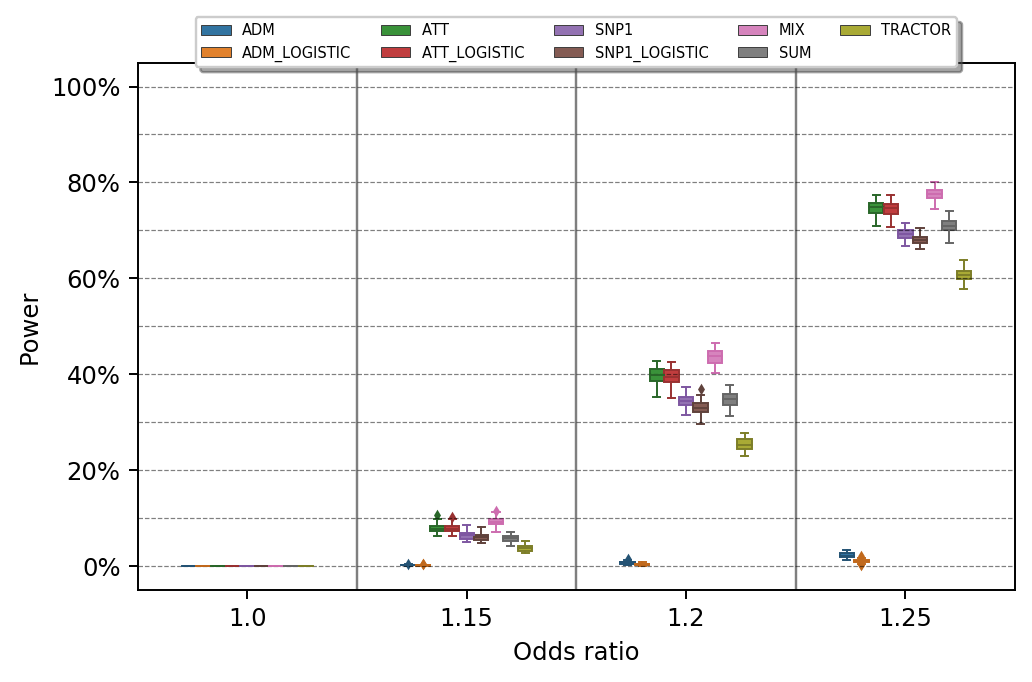

## Sample size: 4k cases & 10k controls, global ancestry effect: 0.0 (all SNPs)

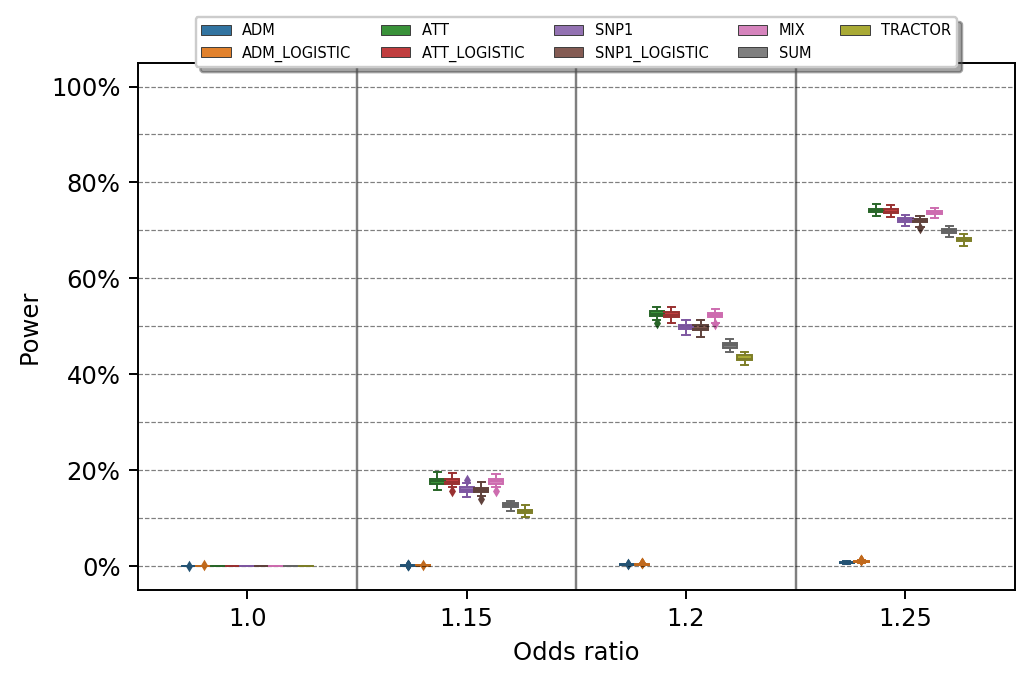

## Sample size: 4k cases & 10k controls, global ancestry effect: 0.0 (differentiated SNPs)

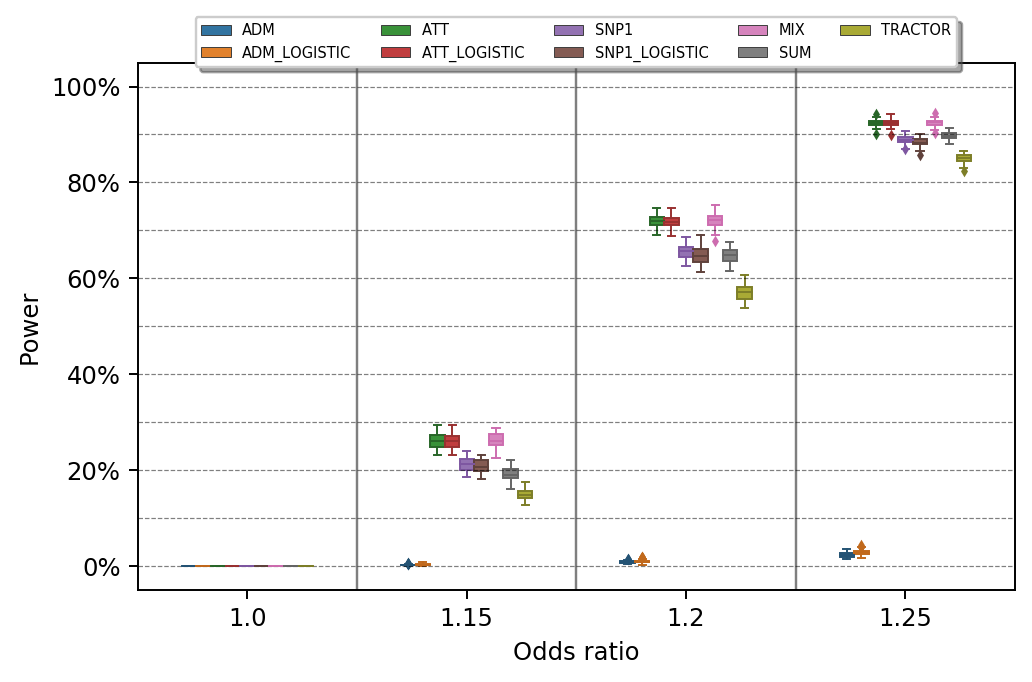

## Sample size: 4k cases & 10k controls, global ancestry effect: 0.5 (all SNPs)

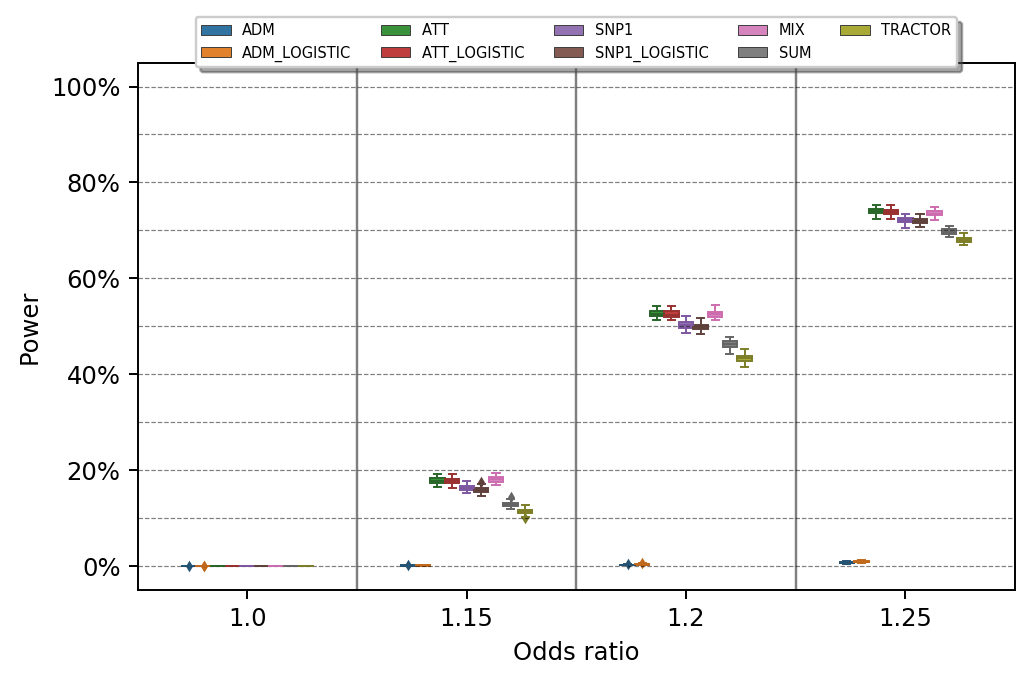

## Sample size: 4k cases & 10k controls, global ancestry effect: 0.5 (differentiated SNPs)

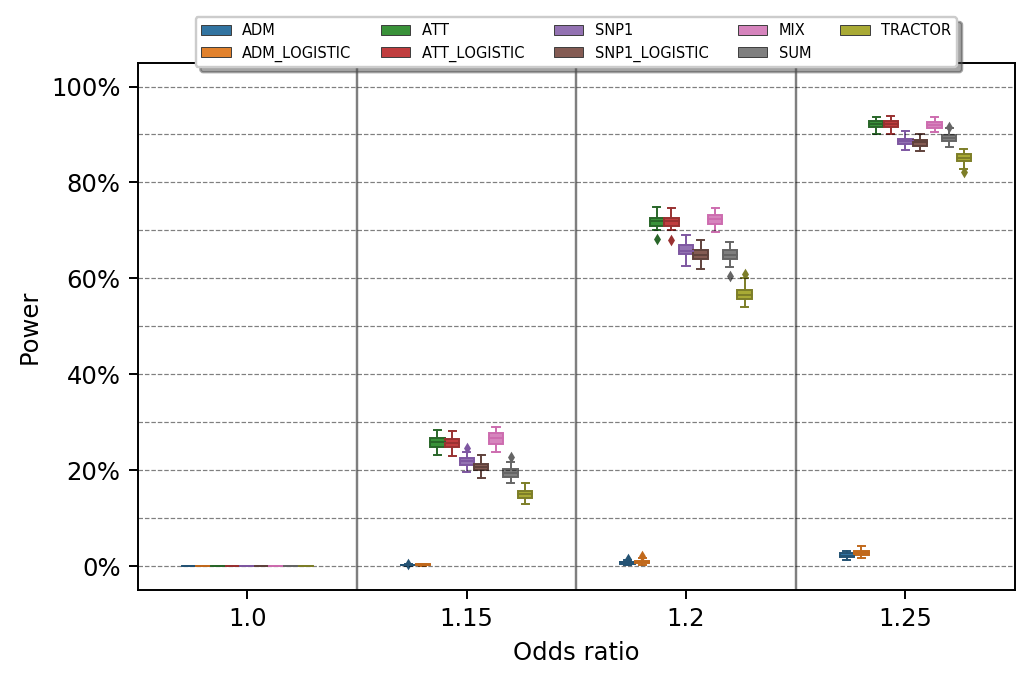

In [7]:
diff_snps = np.where(np.abs(legend.EUR.values - legend.AFR.values) > 0.2)[0]

writer = pd.ExcelWriter('manuscript/power.xlsx', engine='xlsxwriter')

for control_ratio in control_ratio_list:
    for anc_effect in anc_effect_list:
        for only_diff_snp in [False, True]:
            sample_size_text = "4k cases & 4k controls" if control_ratio == 1.0 else "4k cases & 10k controls"
            diff_snp_text = "(differentiated SNPs)" if only_diff_snp else "(all SNPs)"
            display(Markdown(f"## Sample size: {sample_size_text}, global ancestry effect: {anc_effect} {diff_snp_text}"))
            df = {"score": [], "odds_ratio": [], "sig_prop": [], "sim_i": []}
            for odds_ratio in odds_ratio_list:
                pval_df = score_df_dict[control_ratio][(odds_ratio, anc_effect)].copy().dropna()
                if only_diff_snp:
                    pval_df = pval_df[pval_df.SNP_I.isin(diff_snps)]
                for score in pval_df.columns[0:-2]:
                    p_threshold = 1e-5 if score in ["ADM", "ADM_LOGISTIC"] else 5e-8
                    sig_prop = pval_df.groupby("SIM_I").apply(lambda x: np.mean(x[score] < p_threshold))
                    sig_prop_mean = np.mean(sig_prop)
                    sig_prop_se = np.std(sig_prop) / np.sqrt(len(sig_prop))
                    score_n_sim = len(sig_prop)
                    df["score"].extend([score] * score_n_sim)
                    df["odds_ratio"].extend([odds_ratio] * score_n_sim)
                    df["sig_prop"].extend(sig_prop)
                    df["sim_i"].extend(sig_prop.index.values)
            df = pd.DataFrame(df)

            pivotted = df.groupby(["score", "odds_ratio"])["sig_prop"].apply(
                lambda x : f"{np.mean(x):.3f}({np.std(x):.3f})").reset_index().pivot(
                index=["odds_ratio"], columns='score')
            
            sheet_name = f"cr {control_ratio} ae {anc_effect}"
            if only_diff_snp:
                sheet_name += " (diff)"
            
            pivotted.to_excel(writer, sheet_name=sheet_name)
            
            # plotting
            fig, ax = plt.subplots(figsize=(6, 4), dpi=175)
            label_order = ["ADM", "ADM_LOGISTIC", "ATT", "ATT_LOGISTIC", "SNP1", "SNP1_LOGISTIC",
                                   "MIX", "SUM", "TRACTOR"]
            
            sns.boxplot(x="odds_ratio", y="sig_prop",
                        hue="score",
                        hue_order=label_order,
                        width=0.6,
                        linewidth=0.8,
                        fliersize=2,
                        data=df, ax=ax)

            [ax.axvline(i + 0.5, color='k', alpha=0.5, lw=1) for i in range(len(np.unique(df['odds_ratio'])) - 1)]
            lighten_boxplot(ax)
            [ax.axhline(y=i, linestyle='--', color='k', alpha=0.5, lw=0.5) for i in np.linspace(0, 1, 11)]
            ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])
            plt.xlabel("Odds ratio")
            plt.ylabel("Power")
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                  ncol=5, fancybox=True, shadow=True, fontsize=6)
            plt.ylim(-0.05, 1.05)
            plt.tight_layout()
            plt.show()
            
writer.save()

# Association testing when the causal SNP is not typed
We take 1kg SNPs, filter for MAF > 0.01 in both populations and obtain 546k SNPs on CHR 2. We take 300 uniformly sampled SNPs as the causal SNP. For each SNP, we pick 40 nearest SNPs as a region and perform single causal SNP simulation as described above. We show the proportion of SNPs exceeding genome-wide significance with 
- Figure 1: p-value of causal SNPs
- Figure 2: minimum p-value based on the 40 tagging SNPs (masking the true causal SNP)

The larger range of the boxplot is due to that here we have 300 regions, compared to previous results with 3000 SNPs.

In [8]:
geno_data_dir = f"data/geno/finemap_300/"
legend = pd.read_csv(join(geno_data_dir, "legend.csv"))

n_region = 300
region_size = 40
# for each region of size 41, the center SNP is set to be causal, `center_snp_index` index these SNPs
center_snp_index = np.arange(n_region) * (region_size + 1) + region_size // 2
# 1-based indexing for the results
diff_regions = np.where(np.abs(legend.EUR.values[center_snp_index] - legend.AFR.values[center_snp_index]) > 0.2)[0] + 1

In [9]:
score_df_dict = dict()

# read results
for control_ratio in [1.0, 2.5]:
    rls_dir = f"out/multi_snp_test/cp_0.1_cr_{control_ratio}/or_1.2_ae_0.0/"
    score_df = []
    for region_i in range(1, 301):
        rls = pd.read_csv(join(rls_dir, f"region_{region_i}.csv.gz"))
        rls["REGION_I"] = region_i
        score_df.append(rls)
    score_df = pd.concat(score_df)
    score_df_dict[control_ratio] = score_df

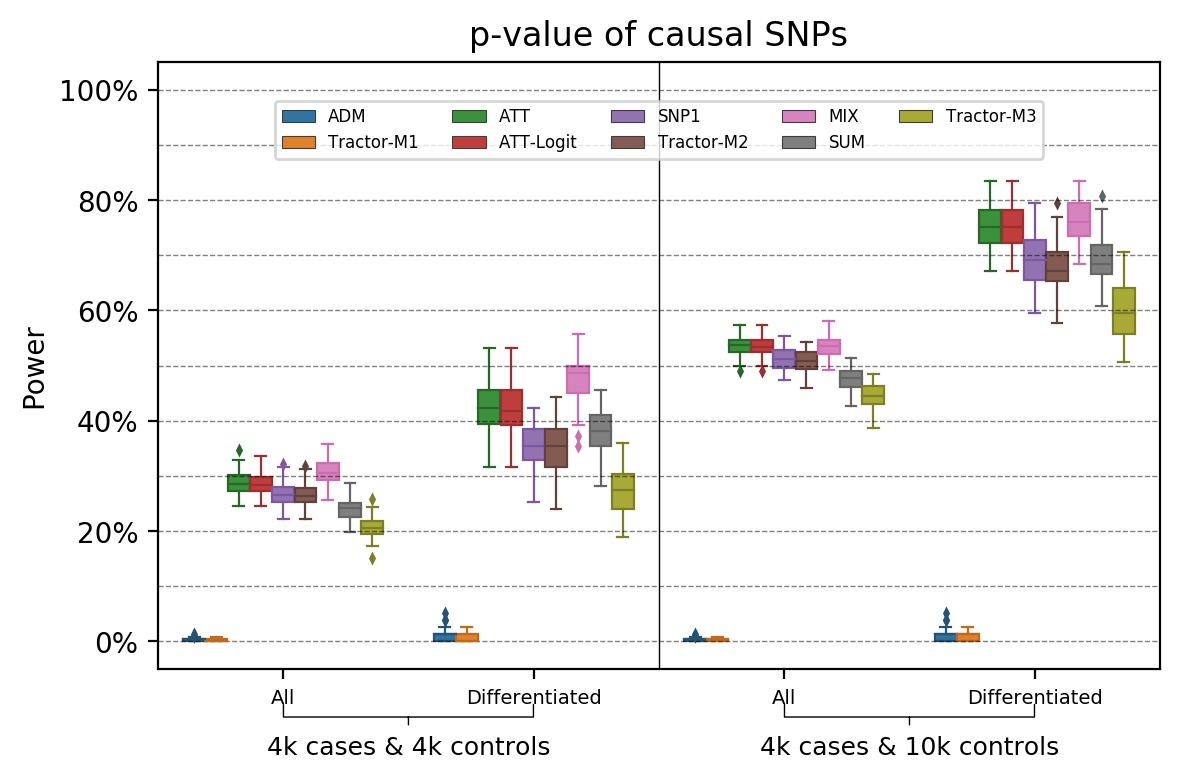

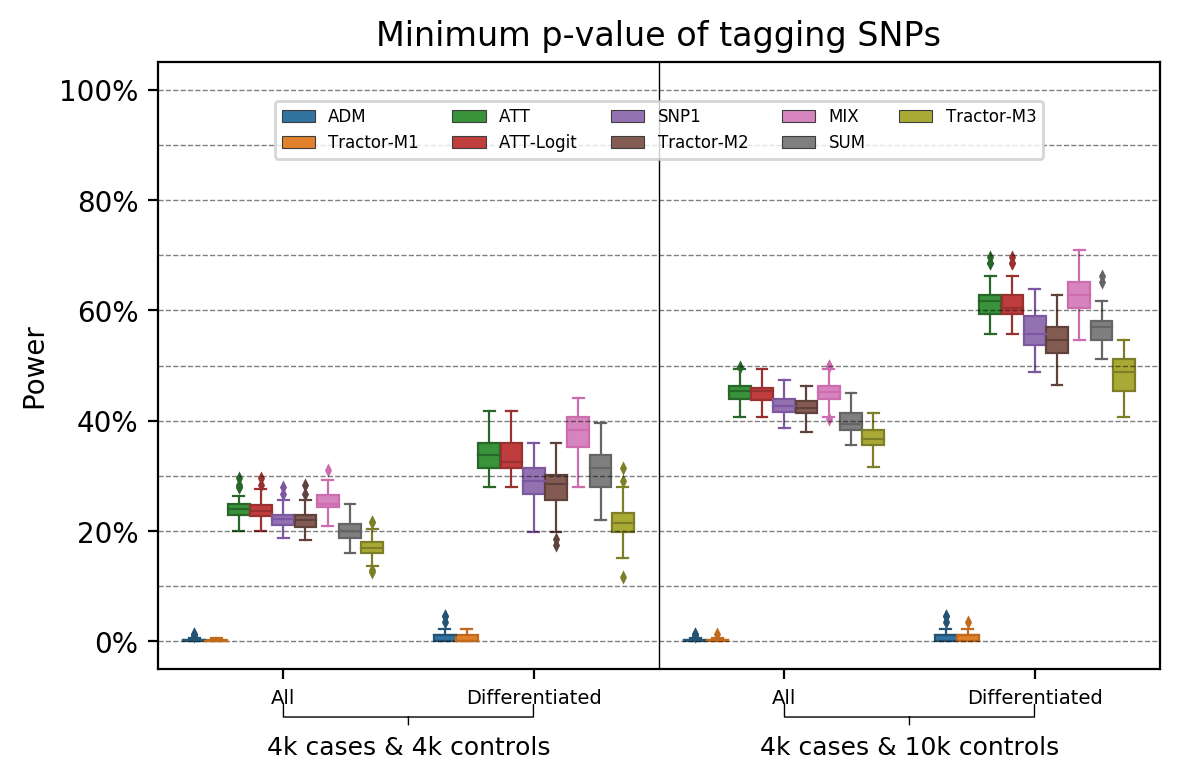

In [10]:
score_names = score_df_dict[1.0].columns[:-3].values

plot_df = {"score": [],
           "sig_prop": [],
           "control_ratio": [],
           "only_diff_region": [],
           "tagging": [],
           "sim_i": []}

for control_ratio in [1.0, 2.5]:
    for tagging in [False, True]:
        pval_df = score_df_dict[control_ratio].dropna()
        if tagging:
            pval_df = pval_df[pval_df.SNP_I != 20]
            pval_df = pval_df.groupby(['SIM_I', "REGION_I"]).agg({col : 'min' for col in score_names}).reset_index()
        else:
            pval_df = pval_df[pval_df.SNP_I == 20]
        for only_diff_region in [False, True]:
            if only_diff_region:
                pval_df = pval_df[pval_df.REGION_I.isin(diff_regions)]
            else:
                pval_df = pval_df.copy()

            for score in score_names:
                p_threshold = 1e-5 if score in ["ADM", "ADM_LOGISTIC"] else 5e-8
                sig_prop = pval_df.groupby("SIM_I").apply(lambda x: np.mean(x[score] < p_threshold))
                score_n_sim = len(sig_prop)
                plot_df["score"].extend([score] * score_n_sim)
                plot_df["control_ratio"].extend([control_ratio] * score_n_sim)
                plot_df["only_diff_region"].extend([only_diff_region] * score_n_sim)
                plot_df["tagging"].extend([tagging] * score_n_sim)
                plot_df["sig_prop"].extend(sig_prop)
                plot_df["sim_i"].extend(sig_prop.index.values)

plot_df = pd.DataFrame(plot_df)

plot_df = plot_df.replace({"ADM_LOGISTIC": "Tractor-M1",
                 "SNP1_LOGISTIC": "Tractor-M2",
                 "TRACTOR": "Tractor-M3",
                 "ATT_LOGISTIC": "ATT-Logit"})

plot_df["xlabel"] = plot_df.apply(lambda row: str(row["control_ratio"]) + str(row["only_diff_region"]), axis = 1)


### central SNP

for is_tagging in [False, True]:
    fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
    label_order = ["ADM", "Tractor-M1", "ATT", "ATT-Logit", "SNP1", "Tractor-M2",
                           "MIX", "SUM", "Tractor-M3"]

    sns.boxplot(x="xlabel", y="sig_prop",
                hue="score",
                hue_order=label_order,
                width=0.8,
                linewidth=0.8,
                fliersize=2,
                data=plot_df[plot_df.tagging == is_tagging], ax=ax)


    lighten_boxplot(ax)

    ax.axvline(1.5, color='k', lw=0.5)
    [ax.axhline(y=i, linestyle='--', color='k', alpha=0.5, lw=0.5) for i in np.linspace(0, 1, 11)]
    ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])

    ax.annotate('4k cases & 4k controls', xy=(0.25, -0.07), xytext=(0.25, -0.15), xycoords='axes fraction', 
                fontsize=9, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=5.0, lengthB=0.5', lw=0.5))

    ax.annotate('4k cases & 10k controls', xy=(0.75, -0.07), xytext=(0.75, -0.15), xycoords='axes fraction', 
                fontsize=9, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=5.0, lengthB=0.5', lw=0.5))

    plt.xlabel("")
    plt.ylabel("Power")
    if is_tagging:
        plt.title("Minimum p-value of tagging SNPs")
    else:
        plt.title("p-value of causal SNPs")
    ax.set_xticklabels(["All", "Differentiated"] * 2, fontsize=7)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,0.95),
          ncol=5, fontsize=6)
    plt.ylim(-0.05, 1.05)
    plt.tight_layout()

In [11]:
print(plot_df.groupby(["control_ratio", "only_diff_region", "tagging", "score"]).agg({"sig_prop": np.mean}).to_string())

                                                   sig_prop
control_ratio only_diff_region tagging score               
1.0           False            False   ADM         0.003108
                                       ATT         0.288422
                                       ATT-Logit   0.286583
                                       MIX         0.306708
                                       SNP1        0.266236
                                       SUM         0.241382
                                       Tractor-M1  0.001200
                                       Tractor-M2  0.264760
                                       Tractor-M3  0.206217
                               True    ADM         0.003267
                                       ATT         0.239867
                                       ATT-Logit   0.238333
                                       MIX         0.253533
                                       SNP1        0.221600
                                       S